In [16]:
import numpy as np
import pandas as pd
import ast
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from API import API


In [2]:
def preprocess_movies():
    movies = pd.read_csv('/Users/Aditya/Downloads/archive 2/tmdb_5000_movies.csv')
    credits = pd.read_csv('/Users/Aditya/Downloads/archive 2/tmdb_5000_credits.csv')
    # Merging the two datasets on 'title'
    movies = movies.merge(credits, on='title')
    # Selecting only the relevant columns
    movies = movies[['movie_id','title','overview','genres','keywords','cast','crew','id']]
    # Remove any rows with missing values
    movies.dropna(inplace=True)

    # Function to extract 'name' fields from JSON-like strings
    def convert(text):
        return [i['name'] for i in ast.literal_eval(text)]
    # Function to extract the director's name from crew
    def fetch_director(text):
        return [i['name'] for i in ast.literal_eval(text) if i['job'] == 'Director']

    # Apply text conversions to columns
    movies['genres'] = movies['genres'].apply(convert)
    movies['keywords'] = movies['keywords'].apply(convert)
    movies['cast'] = movies['cast'].apply(lambda x: convert(x)[:3])
    movies['crew'] = movies['crew'].apply(fetch_director)
    # Preprocess overview by splitting into words
    movies['overview'] = movies['overview'].apply(lambda x: x.split())
    # Combine all useful text features into a single 'tags' column
    movies['tags'] = movies['overview'] + movies['genres'] + movies['keywords'] + movies['cast'] + movies['crew']
    # Join all tokens into one string and convert to lowercase
    movies['tags'] = movies['tags'].apply(lambda x: " ".join(x)).str.lower()
    return movies.reset_index(drop=True)


In [3]:
def build_models(movies):
    # TF-IDF based similarity
    # Remove English stopwords
    # Vectorize the 'tags' text
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(movies['tags'])

    # SVD (Latent Semantic Analysis) for dimensionality reduction
    svd = TruncatedSVD(n_components=100, random_state=42)
    svd_matrix = svd.fit_transform(tfidf_matrix)
    
    # Sentence BERT embeddings for semantic similarity
    sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
    overview_embeddings = sbert_model.encode(movies['tags'].tolist(), show_progress_bar=True)
    
    # Compute cosine similarity matrices for each method
    tfidf_sim = cosine_similarity(tfidf_matrix)
    svd_sim = cosine_similarity(svd_matrix)
    sbert_sim = cosine_similarity(overview_embeddings)
    return tfidf_sim, svd_sim, sbert_sim


In [4]:
def hybrid_recommend(input_titles, movies, tfidf_sim, svd_sim, sbert_sim, w1=0.2, w2=0.3, w3=0.5, top_n=5):
    indices = []

    # Find index of each input movie title
    for title in input_titles:
        if title not in movies['title'].values:
            raise ValueError(f"Movie '{title}' not found!")
        indices.append(movies[movies['title'] == title].index[0])
        
    # Combine similarity scores using weighted average
    sim_scores = sum(w1 * tfidf_sim[idx] + w2 * svd_sim[idx] + w3 * sbert_sim[idx] for idx in indices)
    sim_scores /= len(indices)  # average for multiple movies

     # Get top N most similar movies (excluding the input ones)
    movie_indices = sim_scores.argsort()[-top_n - len(indices):][::-1]
    # Retrieve recommended movies, excluding ones already in input
    recommended = movies.iloc[movie_indices]
    recommended = recommended[~recommended['title'].isin(input_titles)].head(top_n)  # remove input movies
    
    return recommended, sim_scores[movie_indices[:top_n]]


In [5]:
def get_poster_url(movie_id):
    api_key = API
    url = f"https://api.themoviedb.org/3/movie/{movie_id}?api_key={api_key}&language=en-US"
    data = requests.get(url).json()
    if data.get('poster_path'):
        return "https://image.tmdb.org/t/p/w500" + data['poster_path']
    return None

In [6]:
def plot_posters(recommendations):
    fig, ax = plt.subplots(figsize=(15,4))
    for idx, row in enumerate(recommendations.itertuples()):
        poster_url = get_poster_url(row.id)
        if poster_url:
            response = requests.get(poster_url)
            img = Image.open(BytesIO(response.content))
            ax.imshow(img, extent=[idx, idx+1, 0, 1], aspect='auto')
            ax.text(idx + 0.5, -0.1, row.title, ha='center', va='top', fontsize=9, rotation=15, wrap=True)
    
    ax.axis('off')
    plt.xlim(0, len(recommendations))
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

In [7]:
movies = preprocess_movies()
tfidf_sim, svd_sim, sbert_sim = build_models(movies)



Batches: 100%|████████████████████████████████| 151/151 [02:00<00:00,  1.25it/s]


                        title
2405                   Aliens
3160                    Alien
1533                Moonraker
47    Star Trek Into Darkness
373           Mission to Mars


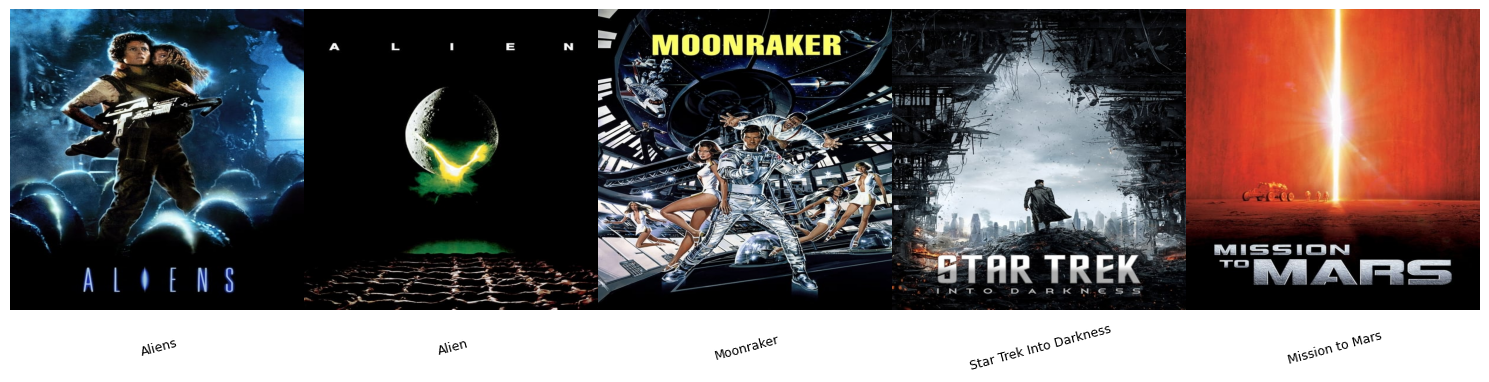

In [17]:
input_movies = ["Avatar"]

recommendations, scores = hybrid_recommend(input_movies, movies, tfidf_sim, svd_sim, sbert_sim, top_n=5)

print(recommendations[['title']])
plot_posters(recommendations)

In [14]:
import joblib
import pickle

# 1) Save your movies dataframe
movies.to_pickle('movies_df.pkl')

# 2) Save your TF-IDF vectorizer and similarity matrix
# joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(tfidf_sim, 'tfidf_sim.pkl')

# 3) Save your TruncatedSVD model and its similarity matrix
# joblib.dump(svd_model, 'svd_model.pkl')
joblib.dump(svd_sim, 'svd_sim.pkl')

# 4) Save your SBERT embeddings (similarity matrix) and, if needed, the model
joblib.dump(sbert_sim, 'sbert_sim.pkl')
# If you want to save the SentenceTransformer itself (it creates its own folder):
# sbert_model.save('sbert_model')  

# 5) (Optional) Pack everything into a single dict
all_objects = {
    'movies': movies,
    #'tfidf_vectorizer': tfidf_vectorizer,
    'tfidf_sim': tfidf_sim,
    #'svd_model': svd_model,
    'svd_sim': svd_sim,
    'sbert_sim': sbert_sim
}
with open('all_components.pkl', 'wb') as f:
    pickle.dump(all_objects, f)
